# `BUILDING A REGRESSION MODEL TO FORECAST SALES` 
#### Using the CRISP-DM framework

## `Business Understanding`


#### Goal/Description
To create a machine learning model to forecast the demand of products in various locations.

#### `Null Hypothesis`
There is no relationship between the average sales and the average sales of the various branches

#### `Alternate Hypothesis`
There is a relationship between the average sales and the average sales of the various branches

### `Key Metrics and Success Criteria`

The success of this poject will be evaluated based on several key metrics and success criteria including;





#### `Analytical Questions`

- Is the train dataset complete (has all the required dates)?
- Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
- Compare the sales for each month across the years and determine which month of which year had the highest sales.
- Did the earthquake impact sales?
- Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
- Are sales affected by promotions, oil prices and holidays?
- What analysis can we get from the date and its extractable features?
- Which product family and stores did the promotions affect.
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
- Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## `Data Understanding`

#### Data Source
The data was sourced from three places:
- Three tables from Corporation Favorita's database 
- Two csv files from a OneDrive location
- Two csv files from a GitHub repository 
 

#### Data Features

- store_nbr : Identifies the store at which the products are sold.

- family : identifies the type of product sold.

- sales : gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

- onpromotion : gives the total number of items in a product family that were being promoted at a store at a given date.

#### Data Exploration

##### `Libraries`

In [2]:
#Libraries imported
import sqlalchemy as sa
import pyodbc  
from dotenv import dotenv_values 
import pandas as pd
from scipy import stats 
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.api import AutoReg
from statsmodels.tsa.arima.model import ARIMA

##### `Database Connection`

In [3]:
#Access protocols for the SQL Database
env_variables = dotenv_values('logins.env')
database = env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')

Python-dotenv could not parse statement starting at line 5


In [4]:
#Creation of Connection to Database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [5]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM oil"

oil_df = pd.read_sql(query, connection,parse_dates= 'date')#,index_col=['date'])
oil_df.info
oil_df.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [6]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM holidays_events"

hdays_df = pd.read_sql(query, connection,parse_dates='date')
hdays_df.info
hdays_df.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM stores"

stores_df= pd.read_sql(query, connection,index_col='store_nbr')
stores_df.tail(10)

,city,state,type,cluster
store_nbr,,,,
45,Quito,Pichincha,A,11
46,Quito,Pichincha,A,14
47,Quito,Pichincha,A,14
48,Quito,Pichincha,A,14
49,Quito,Pichincha,A,11
50,Ambato,Tungurahua,A,14
51,Guayaquil,Guayas,A,17
52,Manta,Manabi,A,11
53,Manta,Manabi,D,13


In [8]:
##Accessing the csv data 
sales_df = pd.read_csv("data\\store-sales-forecasting\\train.csv",parse_dates = ['date'])
sales_df.tail(10)
sales_df.family.nunique()

33

In [9]:
##Accessing the csv data 
transact_df = pd.read_csv("data\\store-sales-forecasting\\transactions.csv",parse_dates = ['date'])
transact_df.head(10)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [10]:
## Call the train dataframe

train_df=pd.read_csv('data\\store-sales-forecasting\\train.csv',parse_dates = ['date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


### DATA UNDERSTANDING

In [11]:
#Checking for missing values
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### EDA

In [12]:
### finding missing days in the sales data
train_df.isnull().sum()

start_day = train_df.date.min()
end_day = train_df.date.max()

print(f'Start Date: {start_day} \n\n End Date : {end_day}')

existing_date = pd.date_range(start=start_day,end = end_day,freq="D")

missing_days = existing_date.difference(train_df['date'])
#missing_dates_train = existing_date[~existing_date.isin(train_df.index)]
print(f'The missing dates are : \n\n {missing_days}')

Start Date: 2013-01-01 00:00:00 

 End Date : 2017-08-15 00:00:00
The missing dates are : 

 DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [13]:
# Function to get the day name from a date string
from dateutil.parser import parse

def get_day_name(date_str):
    return date_str.strftime('%A')


day_names = []
# Get day names for each specific date
for date in missing_days:
    day = get_day_name(date)
    day_names.append(day)


print("Day names for specific dates:")
for date, day_name in zip(missing_days, day_names):
    print(f"{date}: {day_name}")

# Create a DataFrame for missing dates
missing_dates_df = pd.DataFrame({'date': pd.to_datetime(missing_days)})
missing_dates_df.shape
    

Day names for specific dates:
2013-12-25 00:00:00: Wednesday
2014-12-25 00:00:00: Thursday
2015-12-25 00:00:00: Friday
2016-12-25 00:00:00: Sunday


(4, 1)

In [14]:
from itertools import product
missing_dates_train = existing_date[~existing_date.isin(train_df.index)]
store_nbrs = train_df.store_nbr.unique()
family = train_df.family.unique()

missing_products = list(product(store_nbrs,family,missing_days))
missing_products

[(1, 'AUTOMOTIVE', Timestamp('2013-12-25 00:00:00')),
 (1, 'AUTOMOTIVE', Timestamp('2014-12-25 00:00:00')),
 (1, 'AUTOMOTIVE', Timestamp('2015-12-25 00:00:00')),
 (1, 'AUTOMOTIVE', Timestamp('2016-12-25 00:00:00')),
 (1, 'BABY CARE', Timestamp('2013-12-25 00:00:00')),
 (1, 'BABY CARE', Timestamp('2014-12-25 00:00:00')),
 (1, 'BABY CARE', Timestamp('2015-12-25 00:00:00')),
 (1, 'BABY CARE', Timestamp('2016-12-25 00:00:00')),
 (1, 'BEAUTY', Timestamp('2013-12-25 00:00:00')),
 (1, 'BEAUTY', Timestamp('2014-12-25 00:00:00')),
 (1, 'BEAUTY', Timestamp('2015-12-25 00:00:00')),
 (1, 'BEAUTY', Timestamp('2016-12-25 00:00:00')),
 (1, 'BEVERAGES', Timestamp('2013-12-25 00:00:00')),
 (1, 'BEVERAGES', Timestamp('2014-12-25 00:00:00')),
 (1, 'BEVERAGES', Timestamp('2015-12-25 00:00:00')),
 (1, 'BEVERAGES', Timestamp('2016-12-25 00:00:00')),
 (1, 'BOOKS', Timestamp('2013-12-25 00:00:00')),
 (1, 'BOOKS', Timestamp('2014-12-25 00:00:00')),
 (1, 'BOOKS', Timestamp('2015-12-25 00:00:00')),
 (1, 'BOOKS',

In [15]:
missing_df = pd.DataFrame(missing_products, columns=['store_nbr','family', 'date'])

In [16]:
missing_df

,store_nbr,family,date
0,1,AUTOMOTIVE,2013-12-25
1,1,AUTOMOTIVE,2014-12-25
2,1,AUTOMOTIVE,2015-12-25
3,1,AUTOMOTIVE,2016-12-25
4,1,BABY CARE,2013-12-25
...,...,...,...
7123,9,SCHOOL AND OFFICE SUPPLIES,2016-12-25
7124,9,SEAFOOD,2013-12-25
7125,9,SEAFOOD,2014-12-25
7126,9,SEAFOOD,2015-12-25


In [17]:
# function to create the year,month and days
def calender(df): 

    df['monthname'] = df['date'].dt.month_name()
    df['dayname'] = df['date'].dt.day_name()
    df['day']= df['date'].dt.day
    df['year'] = df['date'].dt.year

    return df

In [18]:
missing_df1= calender(missing_df)

missing_df1

,store_nbr,family,date,monthname,dayname,day,year
0,1,AUTOMOTIVE,2013-12-25,December,Wednesday,25,2013
1,1,AUTOMOTIVE,2014-12-25,December,Thursday,25,2014
2,1,AUTOMOTIVE,2015-12-25,December,Friday,25,2015
3,1,AUTOMOTIVE,2016-12-25,December,Sunday,25,2016
4,1,BABY CARE,2013-12-25,December,Wednesday,25,2013
...,...,...,...,...,...,...,...
7123,9,SCHOOL AND OFFICE SUPPLIES,2016-12-25,December,Sunday,25,2016
7124,9,SEAFOOD,2013-12-25,December,Wednesday,25,2013
7125,9,SEAFOOD,2014-12-25,December,Thursday,25,2014
7126,9,SEAFOOD,2015-12-25,December,Friday,25,2015


In [19]:
### Adding the missing dates to the dataframe
# Merge with specific dates to include missing dates
train_df = train_df.reset_index(drop=False)
train_df = pd.concat([train_df, missing_df], ignore_index=True)


In [20]:
train_df['onpromotion'] = train_df['onpromotion'].fillna(0)
train_df['sales'] = train_df['sales'].fillna(0)

In [21]:
train_df = calender (train_df)


In [85]:
train_df.shape

(3008016, 11)

In [22]:
train_copy = train_df.set_index('date')
train_copy.sales.fillna(0,inplace = True)

#### Univariate Analysis

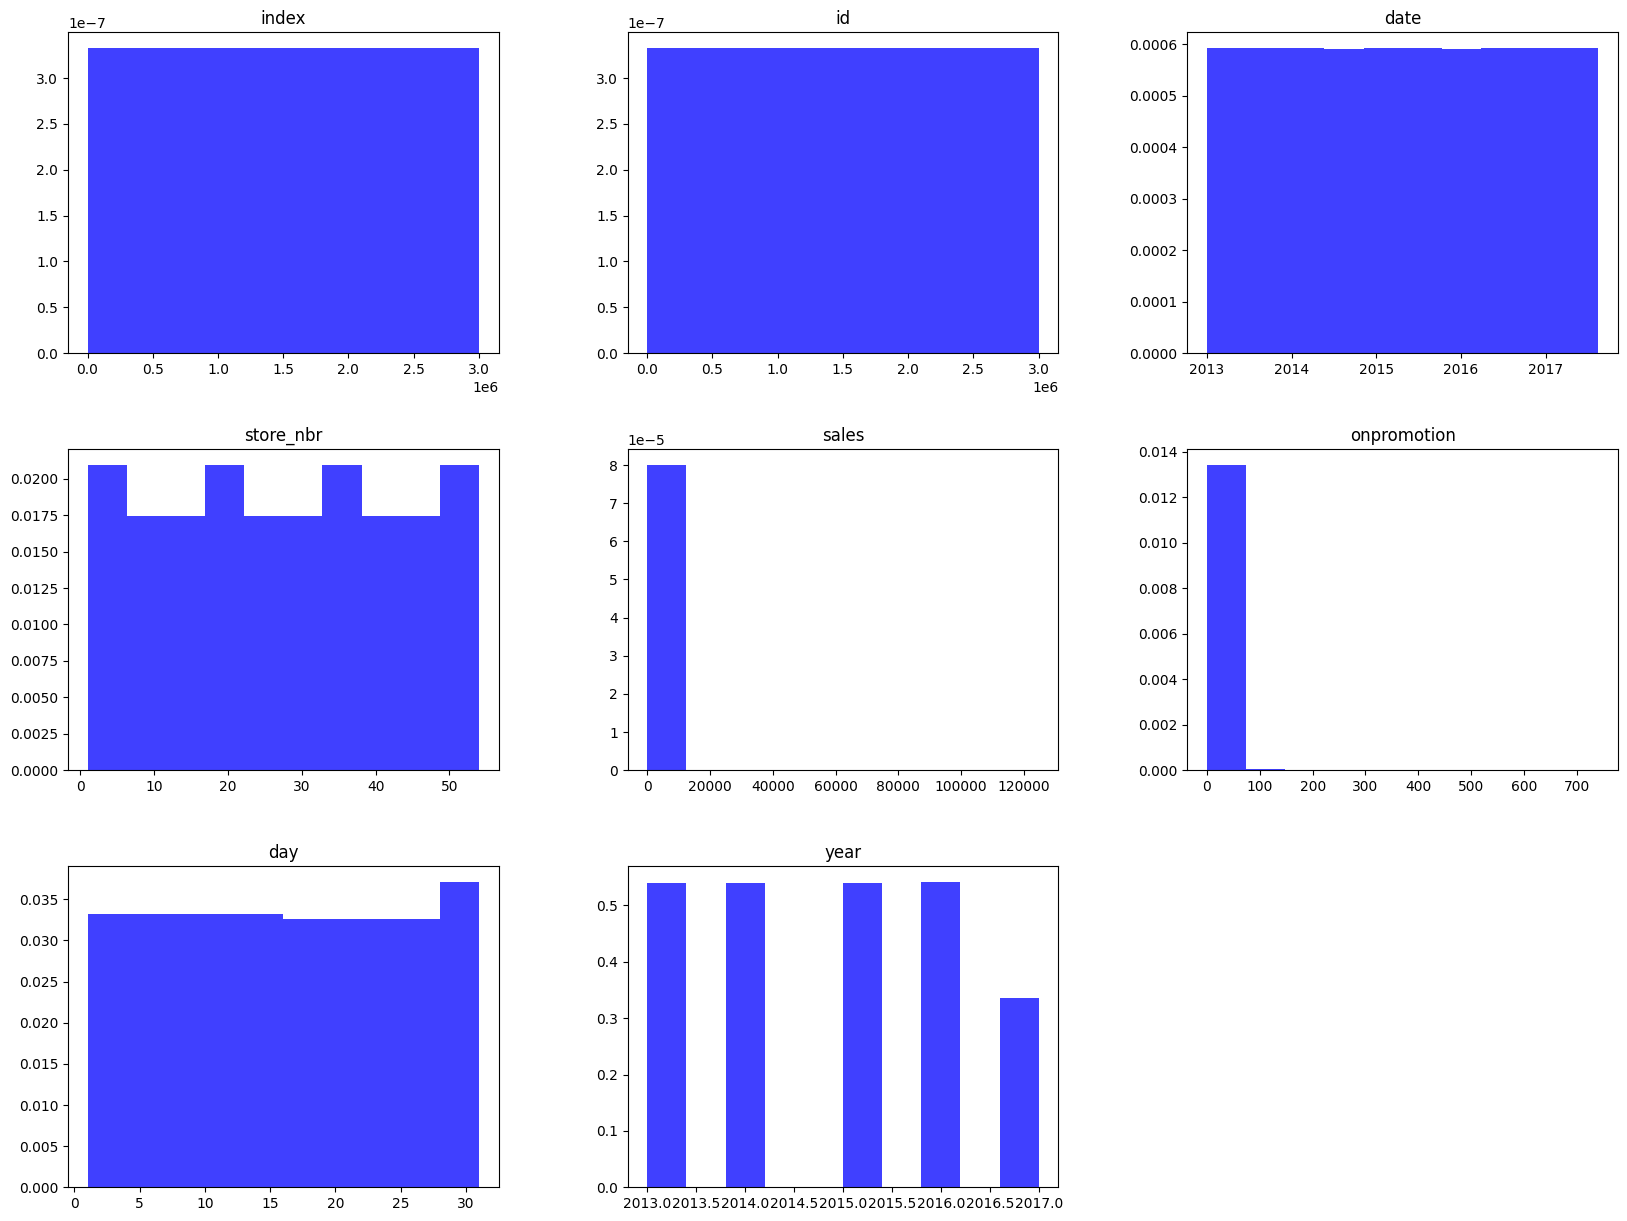

In [23]:
# Distribution of the variables
train_df.hist(density = True,figsize = (20, 15), facecolor = 'blue', alpha = 0.75,grid = False)

plt.show()

<Axes: xlabel='sales', ylabel='Density'>

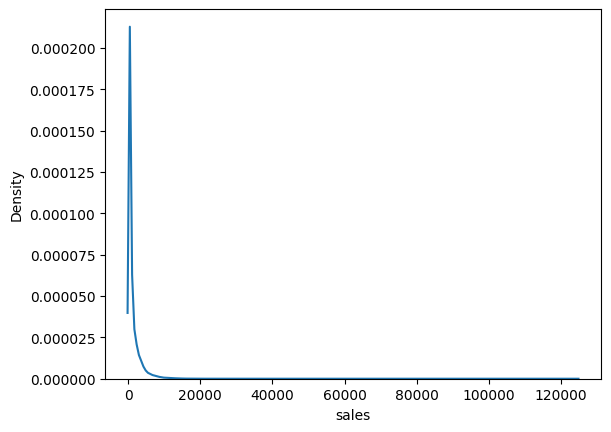

In [24]:
sns.kdeplot(train_df['sales'])

#### Observation
- Sales is left skewed

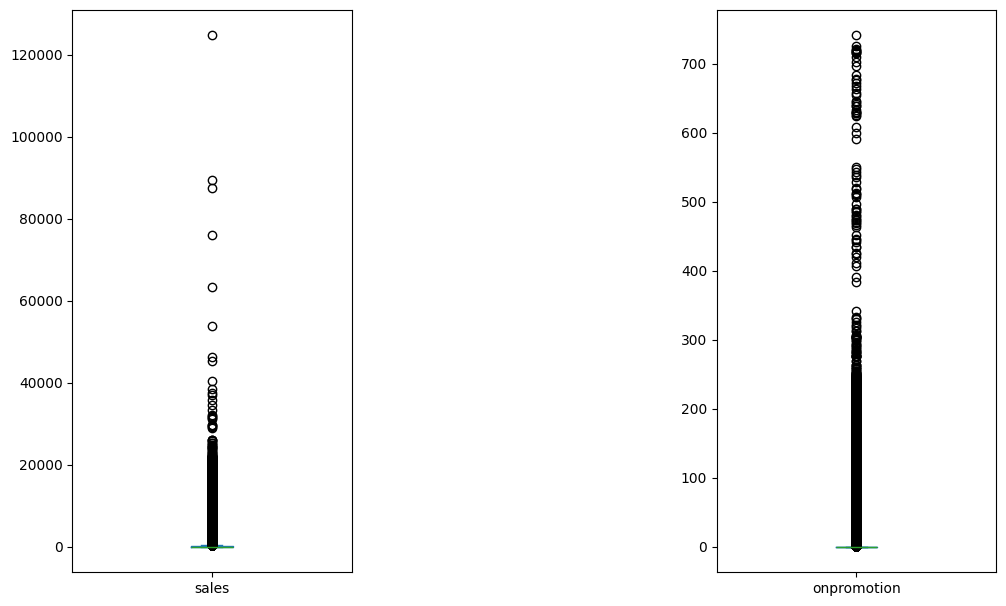

In [25]:
plt.subplot(131)
train_df['sales'].plot.box(figsize=(10,6))
plt.tight_layout(pad=0.5)
plt.subplot(133)
train_df['onpromotion'].plot.box()
plt.tight_layout(pad=0.5)

##### Observation

- A lot of outliers in sales and promotions

##### BiVariate Analysis

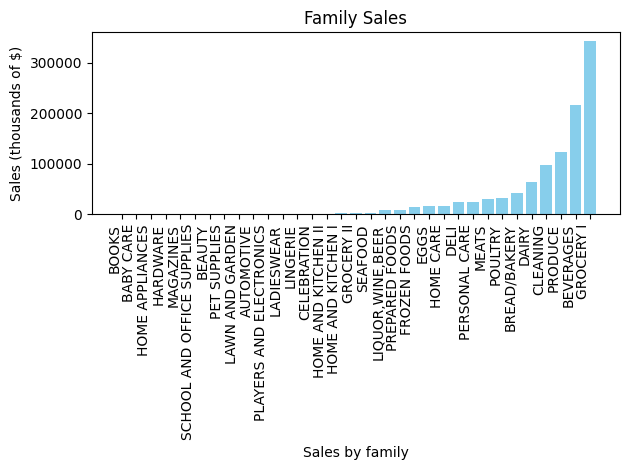

In [26]:
family_sales= (train_df.groupby('family')['sales'].sum()/1000).sort_values(ascending=True)
plt.bar(family_sales.index, family_sales, color='skyblue')
plt.xlabel('Sales by family')
plt.ylabel('Sales (thousands of $)')
plt.title('Family Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


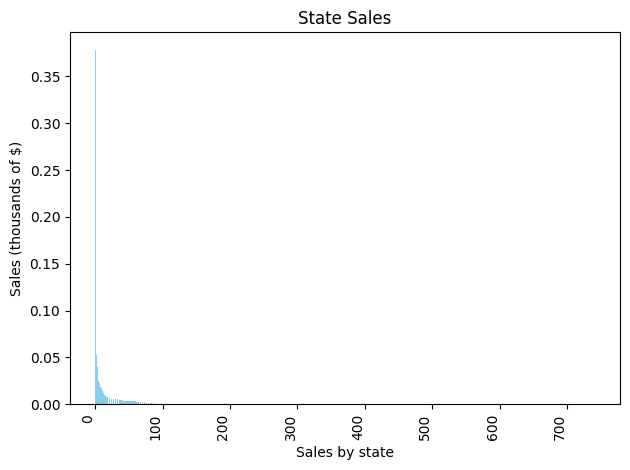

In [27]:
##### Find where there is no promotion

onpromotion_sales= (train_df.groupby('onpromotion')['sales'].sum()/1000000000)
plt.bar(onpromotion_sales.index, onpromotion_sales, color='skyblue')
plt.xlabel('Sales by state')
plt.ylabel('Sales (thousands of $)')
plt.title('State Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

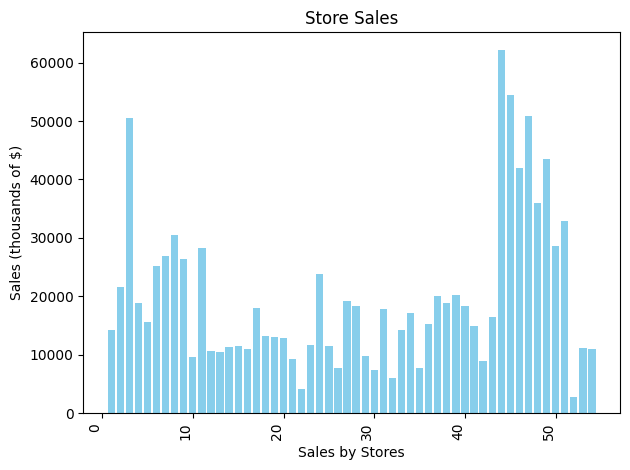

In [28]:
### Use plotly express here

store_sales= (train_df.groupby('store_nbr')['sales'].sum()/1000)
store_sales_sorted=store_sales.sort_values(ascending=False)
store_sales_sorted
plt.bar(store_sales_sorted.index, store_sales_sorted, color='skyblue')
plt.xlabel('Sales by Stores')
plt.ylabel('Sales (thousands of $)')
plt.title('Store Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


#### Analytical Questions

#### Q1 Is the train dataset complete (has all the required dates)?


In [29]:
#missing dates in sales
missing_dates_df

### Merging the missing days with the holidays dataframe
#combined_h_df = pd.merge(missing_dates_df, hdays_df , on='date', how='left') 


,date
0,2013-12-25
1,2014-12-25
2,2015-12-25
3,2016-12-25


In [30]:
## The Dates with no data shows the missing days

###### Check for saturdays and sundays
train_df.isnull().sum()

index          7128
id             7128
date              0
store_nbr         0
family            0
sales             0
onpromotion       0
monthname         0
dayname           0
day               0
year              0
dtype: int64

##### Observation

- Train Dataset is complete


##### Q2 Which dates have the lowest and highest sales for each year (excluding days the store was closed)?


In [31]:
#Taking out all the zero values

non_zero_values = train_df[train_df.sales != 0].set_index('date')
unique_years= train_df.year.unique()
unique_years

data = pd.DataFrame(columns=['year', 'min_sales_date', 'max_sales_date'])

for d in unique_years:
    year= non_zero_values[non_zero_values.year == d]
    min_index = year.sales.idxmin()
    max_index= year.sales.idxmax()

    data.loc[len(data)] = d,min_index,max_index


data

,year,min_sales_date,max_sales_date
0,2013,2013-08-06,2013-11-12
1,2014,2014-12-05,2014-12-08
2,2015,2015-09-15,2015-12-14
3,2016,2016-06-23,2016-05-02
4,2017,2017-02-09,2017-04-02


#### Observation
From the data given : 
- From 2013-2015 ,the company had its maximum sales in the last quarter. 
- From 2016 - 2017 ,the company had its maximum sales mid-year

#### Q3 Compare the sales for each month across the years and determine which month of which year had the highest sales.


In [32]:
###resample or groupby

train_copy.onpromotion.fillna(0,inplace = True)
# Downsample to monthly data by taking the mean
monthly_data = train_copy.sales.resample('ME').sum()



fig = px.line(monthly_data, x=monthly_data.index, y='sales', title='Yearly Sales Trend')

# Show the plot
fig.show()

##### Observation
- December 2016 had the highest sales of $ 29.64 million

#### Q4 Did the earthquake impact sales?


In [132]:
# Filter data between start_date and end_date
start_date = '2016-04-01'
end_date = '2016-04-30'
filtered_data = train_df[(train_df['date'] >= start_date) & (train_df['date'] <= end_date)]

filtered_data
fig = px.bar(filtered_data, x=filtered_data.date, y='sales', title=f'Store Sales by {a}')

# Show the plot
fig.show()

#### Observation
vcbvnnnn

#### Q5 Are certain stores or groups of stores selling more products? (Cluster, city, state, type)


In [33]:
### Merging the sales and oil dataframes
store_sales_df = pd.merge(train_df, stores_df , on='store_nbr', how='left') 

for a in ['cluster','state','city','type']:

    store_sales= (store_sales_df.groupby(a)['sales'].sum()/1000000)
    store_sales_sorted=store_sales.sort_values(ascending=True)
    fig = px.line(store_sales, x=store_sales.index, y='sales', title=f'Store Sales by {a}')

# Show the plot
    fig.show()


#### Q6 Are sales affected by promotions, oil prices and holidays?


In [34]:
### Merging the sales and oil dataframes
combined_df = pd.merge(train_df, hdays_df , on='date', how='left')

In [35]:
promotional_sales = combined_df[(combined_df.onpromotion > 0)].sales.sum()/1000000
non_promotional_sales = combined_df[(combined_df.onpromotion == 0)].sales.sum()/1000000

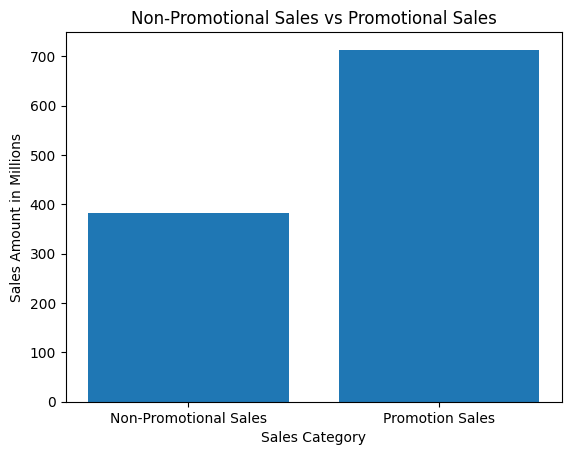

In [36]:
categories = ['Non-Promotional Sales', 'Promotion Sales']
values = [non_promotional_sales, promotional_sales]

# Create a bar chart
plt.bar(categories, values)

# Add labels and title
plt.xlabel('Sales Category')
plt.ylabel('Sales Amount in Millions')
plt.title('Non-Promotional Sales vs Promotional Sales')
plt.show()

In [37]:
### finding missing days in the sales data
oil_df.isnull().sum()

start_day = oil_df.date.min()
end_day = oil_df.date.max()

print(f'Start Date: {start_day} \n\n End Date : {end_day}')

existing_date = pd.date_range(start=start_day,end = end_day,freq="D")

missing_days = existing_date.difference(oil_df['date'])
#missing_dates_train = existing_date[~existing_date.isin(train_df.index)]
print(f'The missing dates are : \n\n {missing_days}')

Start Date: 2013-01-01 00:00:00 

 End Date : 2017-08-31 00:00:00
The missing dates are : 

 DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13', '2017-08-19', '2017-08-20',
               '2017-08-26', '2017-08-27'],
              dtype='datetime64[ns]', length=486, freq=None)


In [38]:
# Function to get the day name from a date string
from dateutil.parser import parse

def get_day_name(date_str):
    return date_str.strftime('%A')


day_names = []
# Get day names for each specific date
for date in missing_days:
    day = get_day_name(date)
    day_names.append(day)


print("Day names for specific dates:")
for date, day_name in zip(missing_days, day_names):
    print(f"{date}: {day_name}")

# Create a DataFrame for missing dates
missing_dates_df = pd.DataFrame({'date': pd.to_datetime(missing_days)})
missing_dates_df.shape
    

Day names for specific dates:
2013-01-05 00:00:00: Saturday
2013-01-06 00:00:00: Sunday
2013-01-12 00:00:00: Saturday
2013-01-13 00:00:00: Sunday
2013-01-19 00:00:00: Saturday
2013-01-20 00:00:00: Sunday
2013-01-26 00:00:00: Saturday
2013-01-27 00:00:00: Sunday
2013-02-02 00:00:00: Saturday
2013-02-03 00:00:00: Sunday
2013-02-09 00:00:00: Saturday
2013-02-10 00:00:00: Sunday
2013-02-16 00:00:00: Saturday
2013-02-17 00:00:00: Sunday
2013-02-23 00:00:00: Saturday
2013-02-24 00:00:00: Sunday
2013-03-02 00:00:00: Saturday
2013-03-03 00:00:00: Sunday
2013-03-09 00:00:00: Saturday
2013-03-10 00:00:00: Sunday
2013-03-16 00:00:00: Saturday
2013-03-17 00:00:00: Sunday
2013-03-23 00:00:00: Saturday
2013-03-24 00:00:00: Sunday
2013-03-30 00:00:00: Saturday
2013-03-31 00:00:00: Sunday
2013-04-06 00:00:00: Saturday
2013-04-07 00:00:00: Sunday
2013-04-13 00:00:00: Saturday
2013-04-14 00:00:00: Sunday
2013-04-20 00:00:00: Saturday
2013-04-21 00:00:00: Sunday
2013-04-27 00:00:00: Saturday
2013-04-28 0

(486, 1)

In [39]:
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].bfill()

In [40]:
### Merging the sales and oil dataframes
combined_df = pd.merge(train_df, oil_df , on='date', how='left')
combined_df = combined_df.dropna()

In [41]:
combined_df.isnull().sum()

index          0
id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
monthname      0
dayname        0
day            0
year           0
dcoilwtico     0
dtype: int64

In [42]:
oil_sales = combined_df.sort_values(by='dcoilwtico', ascending=False)

# Select the first 50 rows and sum their 'sales' values
sum_of_top_50_sales = oil_sales['sales'].head(50).sum()/1000000

# Select the last 50 rows and sum their 'sales' values
sum_of_bottom_50_sales = oil_sales['sales'].tail(50).sum()/1000000


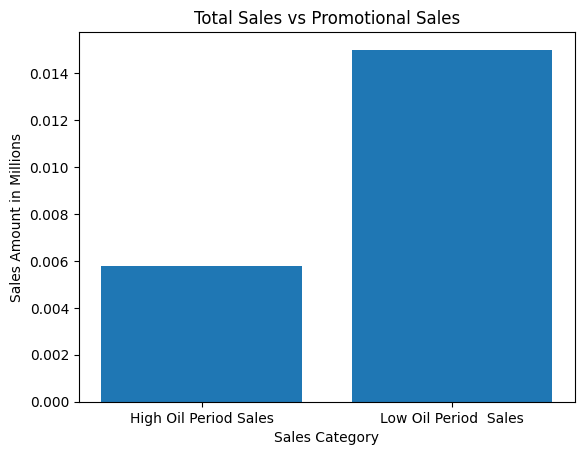

In [43]:
categories = ['High Oil Period Sales', 'Low Oil Period  Sales']
values = [sum_of_top_50_sales , sum_of_bottom_50_sales ]

# Create a bar chart
plt.bar(categories, values)

# Add labels and title
plt.xlabel('Sales Category')
plt.ylabel('Sales Amount in Millions')
plt.title('Total Sales vs Promotional Sales')
plt.show()

In [44]:
### Merging the sales and oil dataframes
combined_df = pd.merge(train_df, hdays_df , on='date', how='left')
combined_df = combined_df.dropna()

In [45]:
####Looking holidays only
holiday_sales = combined_df[(combined_df.type == 'Holiday')].sales.sum()/1000000
non_holiday_sales = combined_df[(combined_df.type != 'Holiday')].sales.sum()/1000000


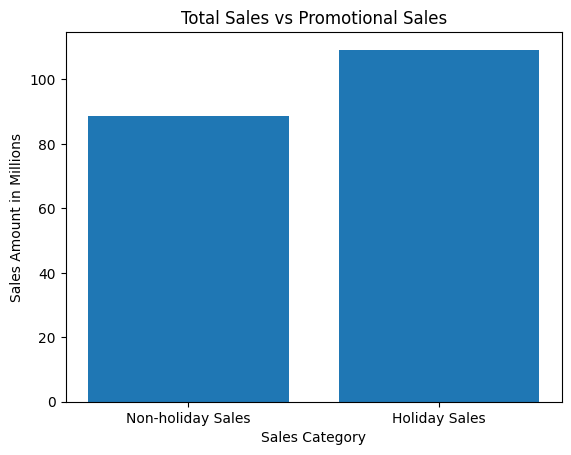

In [46]:
categories = ['Non-holiday Sales', 'Holiday Sales']
values = [non_holiday_sales, holiday_sales]

# Create a bar chart
plt.bar(categories, values)

# Add labels and title
plt.xlabel('Sales Category')
plt.ylabel('Sales Amount in Millions')
plt.title('Total Sales vs Promotional Sales')
plt.show()

#### Observation

- It can be clearly seen that sales are much higher on promotion days or holidays

### Q7 What analysis can we get from the date and its extractable features?

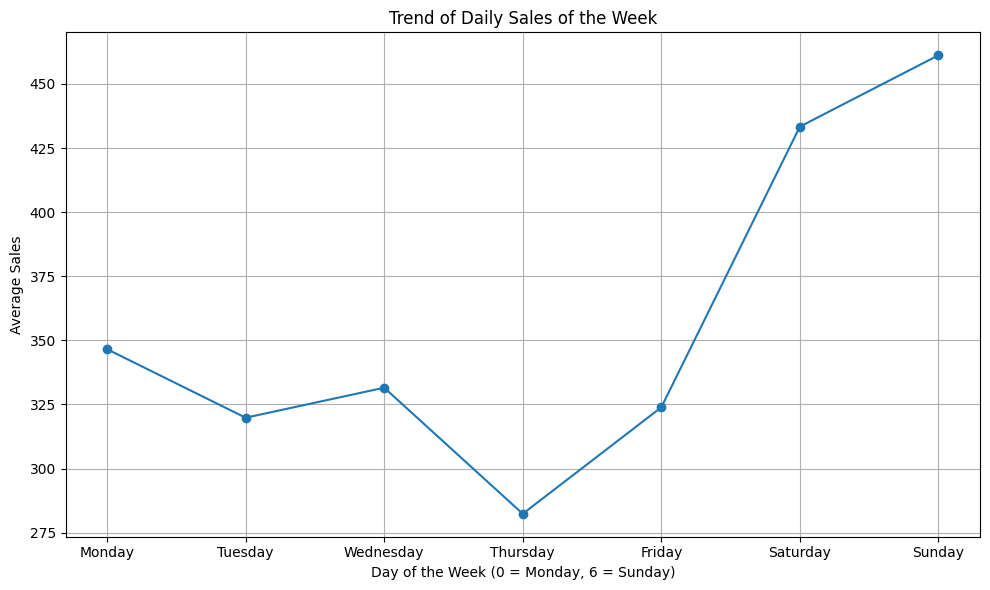

In [47]:
train_df.head(5)
# Group by day of the week and calculate the mean sales for each day
daily_sales = train_df.groupby(train_df['date'].dt.dayofweek)['sales'].mean()

daily_sales
# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(daily_sales.index, daily_sales.values, marker='o')

# Customize the plot
plt.xlabel('Day of the Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Sales')
plt.title('Trend of Daily Sales of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


#### Q8 Which product family and stores did the promotions affect.


In [48]:
promotions_df = store_sales_df[store_sales_df.onpromotion != 0]
promotions_df.head(3)

,index,id,date,store_nbr,family,sales,onpromotion,monthname,dayname,day,year,city,state,type,cluster
810784,810784.0,810784.0,2014-04-01,9,CLEANING,1752.0,3.0,April,Tuesday,1,2014,Quito,Pichincha,B,6
810789,810789.0,810789.0,2014-04-01,9,GROCERY I,7685.0,5.0,April,Tuesday,1,2014,Quito,Pichincha,B,6
812571,812571.0,812571.0,2014-04-02,9,GROCERY I,6481.0,3.0,April,Wednesday,2,2014,Quito,Pichincha,B,6


In [49]:
promotions_stores = promotions_df.groupby(['store_nbr'])['onpromotion'].count().sort_values(ascending=False)

promotions_stores.head(10)

#### Graph


store_nbr
46    15116
48    14996
47    14734
45    14461
44    14208
50    14175
6     13939
49    13864
3     13719
38    13352
Name: onpromotion, dtype: int64

#### Observation

- It can be observed that most of the promotions were done in 2016-2017 which can speak to the highest sales deviating from the usual Christmas period to May
- Store number 53 in Manta,Manabi had the overall highest number of promotions which occured in May,2016 
- Store number 54 in El Carmen in the same state as store number 53 followed closely with 797 promotions.


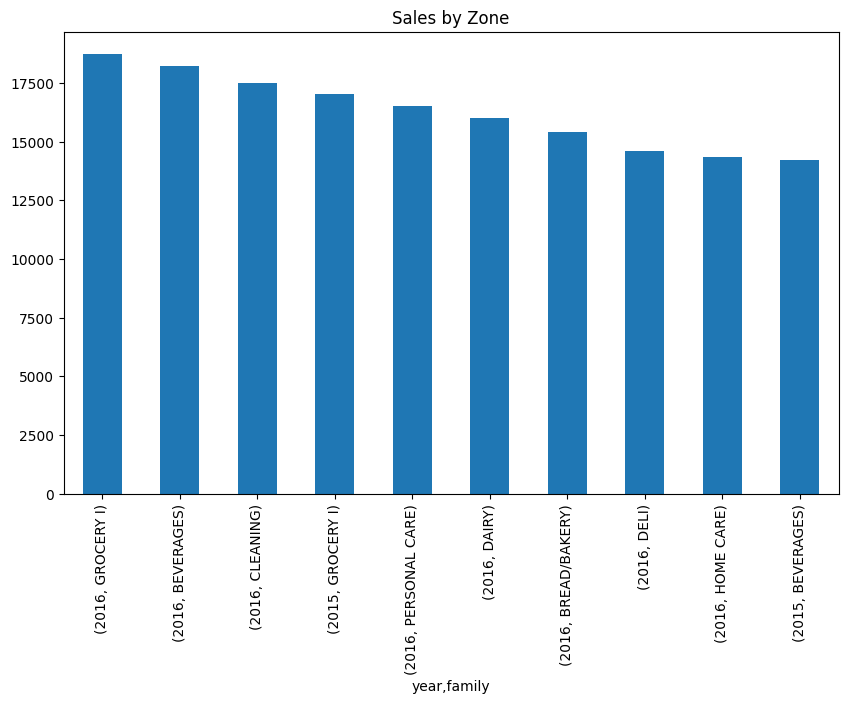

In [82]:
promotions_family = promotions_df.groupby(['year','family'])['onpromotion'].count().sort_values(ascending=False)
promotions_top_10=promotions_family.head(10)
promotions_top_10.plot(kind='bar', x='family', y='onpromotion', title = 'Sales by Zone', 
 figsize = (10,6));
### Graph

#### Observation

- A whole range of pdts /................................
- Be...............................1705 promotions 


In [84]:
#What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

#### Leave it


#### Q9 Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [102]:
salary_15th_day_df = store_sales_df[(store_sales_df.day == 15)].sales.sum()/1000000
salary_days_df = store_sales_df[(store_sales_df.day > 25)].sales.sum()/1000000
normal_days_df = store_sales_df[(store_sales_df.day != 15) & (store_sales_df.day < 25)].sales.sum()/1000000

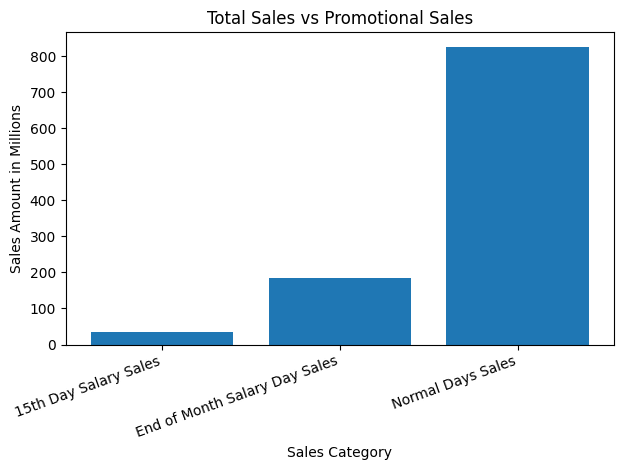

In [112]:
categories = ['15th Day Salary Sales', 'End of Month Salary Day Sales','Normal Days Sales']
values = [salary_15th_day_df,salary_days_df,normal_days_df]

# Create a bar chart
plt.bar(categories, values)

# Add labels and title
plt.xlabel('Sales Category')
plt.ylabel('Sales Amount in Millions')
plt.title('Total Sales vs Promotional Sales')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

##### Observation
- Sales clearly doesnt depend on salary days

### Hypothesis
#There is no relationship between the average sales and the average sales on promotion.

In [57]:
#Checking Normality of the data 

def check_normality(data,name):
    test_stat_normality, p_value_normality = stats.shapiro(data)
    print("p value:%.20f" % p_value_normality)
    if p_value_normality < 0.05:
        print(f"Reject null hypothesis >> The data for {name} is not normally distributed")
    else:
        print(f"Fail to reject null hypothesis >> The data for {name} is normally distributed")

In [58]:
train_copy.head(2)

,index,id,store_nbr,family,sales,onpromotion,monthname,dayname,day,year
date,,,,,,,,,,
2013-01-01,0.0,0.0,1,AUTOMOTIVE,0.0,0.0,January,Tuesday,1,2013
2013-01-01,1.0,1.0,1,BABY CARE,0.0,0.0,January,Tuesday,1,2013


In [59]:
onpromo = train_copy[train_copy.onpromotion != 0].sales
avg_sales= train_copy.sales

In [60]:
#Normality Checks
check_normality(onpromo,'Onpromo')
check_normality(avg_sales,'Sales')

p value:0.00000000000000000000
Reject null hypothesis >> The data for Onpromo is not normally distributed
p value:0.00000000000000000000
Reject null hypothesis >> The data for Sales is not normally distributed


In [61]:
#Using the P-Levene to test the Hypothesis
stat, pvalue_levene = stats.levene(onpromo,avg_sales )

print("p value:%.10f" % pvalue_levene)
if pvalue_levene < 0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.0000000000
Reject null hypothesis >> The variances of the samples are different.


##### Observation 
- Data samples are not normally distributed
- The variances of the samples are different
- Therefore a Non-Parametric test must be done (Kruskal Test)

In [62]:
#Kruskal Test

stat, p = kruskal(onpromo,avg_sales )
print('Statistics=%.3f, p=%.15f' % (stat, p))

if p > 0.05:
 print('All sample distributions are the same (fail to reject H0)')
else:
 print('One or more sample distributions are not equal distributions (reject null Hypothesis)')

Statistics=546943.953, p=0.000000000000000
One or more sample distributions are not equal distributions (reject null Hypothesis)


In [127]:
import scipy.stats as stats

#perform two sample t-test
results= stats.ttest_ind(a=onpromo, b=avg_sales) 

print(results.pvalue,results.statistic)

print("p value:%.7f" % results.pvalue)
if results.pvalue < 0.05:
    print("Reject null hypothesis >> Since the p_value {results.pvalue} is less than 0.05")
else:
    print("Fail to reject null hypothesis >> Since the p_value {results.pvalue} is greater than 0.05")

0.0 435.18547128579235
p value:0.0000000
Reject null hypothesis >> Since the p_value {results.pvalue} is less than 0.05


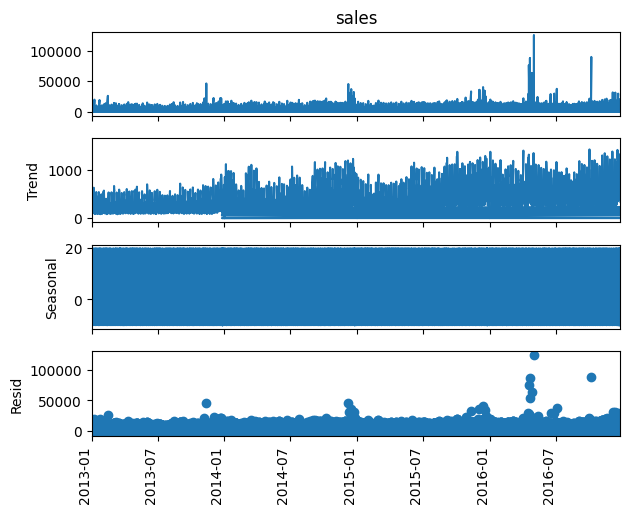

In [128]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
##Overflow Issue resolution
import matplotlib.style as mplstyle
mplstyle.use('fast')
#ts = train_copy.set_index('date')['sales'] 
result = seasonal_decompose(train_copy.sales, model='additive', period=365,extrapolate_trend= 'freq')

result.plot()
plt.xticks(rotation=90, ha='right')
plt.show()

#### Observation
- There is a trend in the train data
- There are residuals present in the train data

In [64]:
train_copy.sales

date
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
             ... 
2016-12-25    0.0
2013-12-25    0.0
2014-12-25    0.0
2015-12-25    0.0
2016-12-25    0.0
Name: sales, Length: 3008016, dtype: float64

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

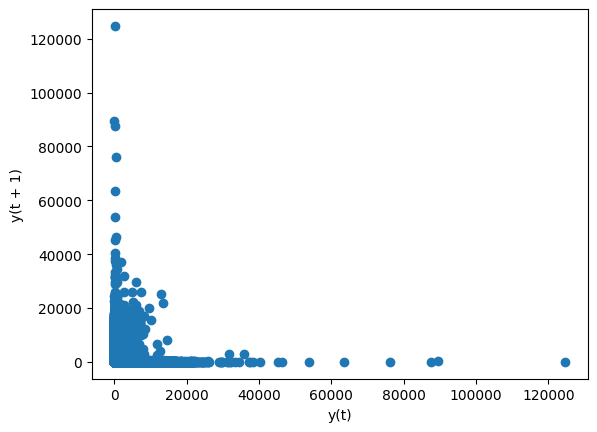

In [133]:
### Autocorelation 
pd.plotting.lag_plot(train_copy.sales,lag=1)

<Axes: xlabel='y(t)', ylabel='y(t + 3)'>

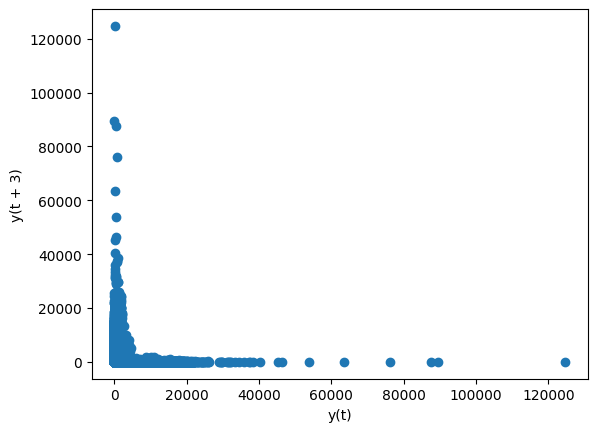

In [66]:
### Autocorelation 
pd.plotting.lag_plot(train_copy.sales,lag=3)

<Axes: xlabel='y(t)', ylabel='y(t + 24)'>

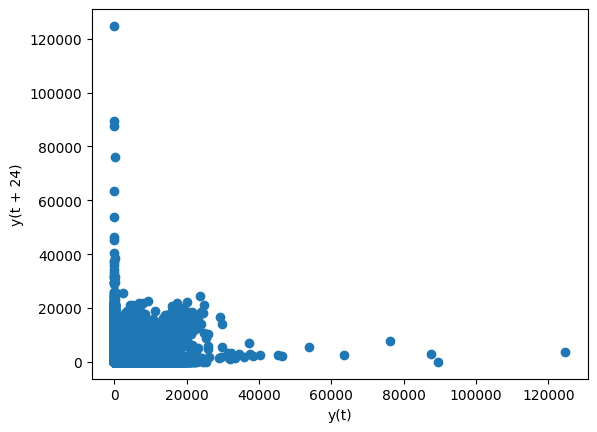

In [67]:
### Autocorelation 
pd.plotting.lag_plot(train_copy.sales,lag=24)

In [138]:
weekly_sales = train_copy.sales.resample("W").sum()/1000

In [139]:
len(weekly_sales)

242

In [140]:
## Autocorrelation Tests using Ljung-Box method

from statsmodels.stats.diagnostic import acorr_ljungbox


# Perform the Ljung-Box test
lags = 5  # Number of lags to consider
results = acorr_ljungbox(weekly_sales, lags=lags,return_df=True)

# Print the test statistic and p-value
lb_p_value = results['lb_pvalue'][1] 
lb_test_statistic = results['lb_stat'][1] 



if lb_p_value < 0.05:
    print('Reject null hypothesis of no autocorrelation')
else:
    print('Accept null hypothesis of no autocorrelation')


Reject null hypothesis of no autocorrelation


In [142]:
## Test for stationarity using AD Fuller Test

from statsmodels.tsa.stattools import adfuller
 

# ADF Test
result = adfuller(weekly_sales)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
if result[1] < 0.05:
    print('The Series possess a unit root and therefore is not Stationary')
else:
    print('The Series is stationary')

ADF Statistic: -1.9137834914190974
n_lags: 0.32560496181472726
p-value: 0.32560496181472726
Critial Values:
   1%, -3.458854867412691
Critial Values:
   5%, -2.8740800599399323
Critial Values:
   10%, -2.573453223097503
The Series is stationary


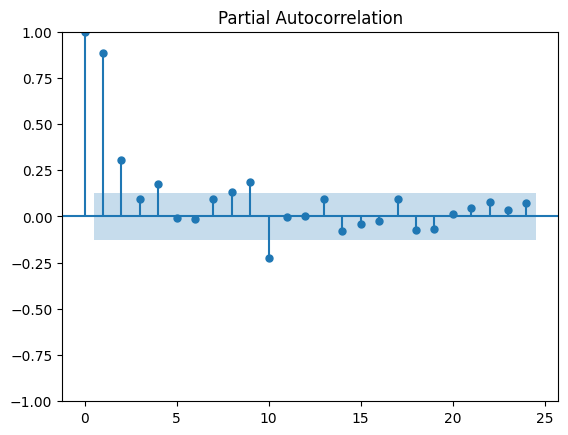

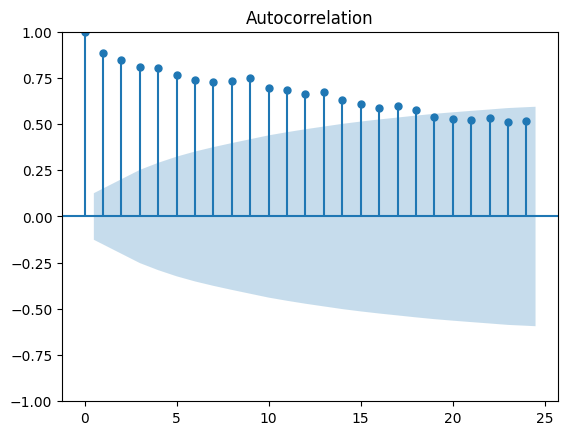

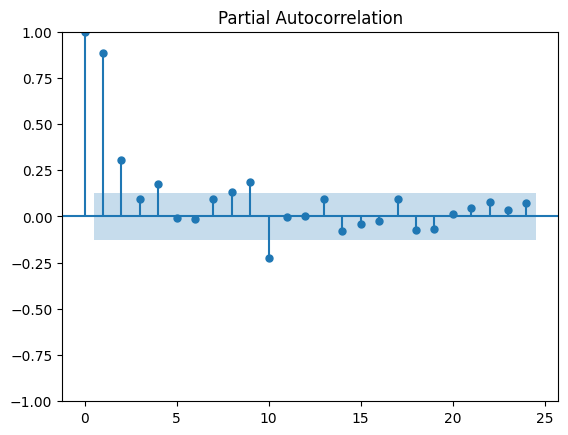

In [143]:
# ## Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# plot the auto correlation
plot_acf(weekly_sales)
plot_pacf(weekly_sales)

### Time series analysis is a method used for analysing time series data in order to extract meaningful statistical information from the data. Time series forecasting however, is all about predicting future values based on previously observed values over time.

##### 10 time series forecasting algorithm
- Autoregressive (AR)
- Autoregressive Integrated Moving Average (ARIMA) for stationary data
- Seasonal Autoregressive Integrated Moving Average (SARIMA) for seasonal data
- Exponential Smoothing (ES)
- XGBoost
- Prophet
- LSTM (Deep Learning)
- DeepAR
- N-BEATS
- Temporal Fusion Transformer (Google)

#### Building Statistical models for time series data

In [73]:
## ARIMA

from pmdarima import auto_arima

stepwise_fit = auto_arima(weekly_sales,trace=True,suppress_warnings = True)
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3743.278, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3770.960, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3752.321, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3747.809, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3768.967, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3751.798, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3743.655, Time=0.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3745.190, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3742.458, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3742.749, Time=0.41 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3744.452, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3748.014, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  242
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -1865.393
Date:                Sat, 04 May 2024   AIC                           3740.786
Time:                        10:00:33   BIC                           3758.210
Sample:                    01-06-2013   HQIC                          3747.806
                         - 08-20-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5843      0.261     -2.238      0.025      -1.096      -0.073
ma.L1          0.2169      0.247      0.878      0.380      -0.268       0.701
ma.L2         -0.2971      0.143     -2.073      0.038      -0.578      -0.016
ma.L3         -0.2773      0.085     -3.263      0.001      -0.444      -0.111
sigma2      3.085e+05   1.25e+04     24.676      0.000    2.84e+05    3.33e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1936.09
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error,root_mean_squared_log_error

In [147]:
   
# Define SARIMA parameters
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 52  # Assuming monthly seasonality
 
# Fit the SARIMA model
model = SARIMAX(weekly_sales, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

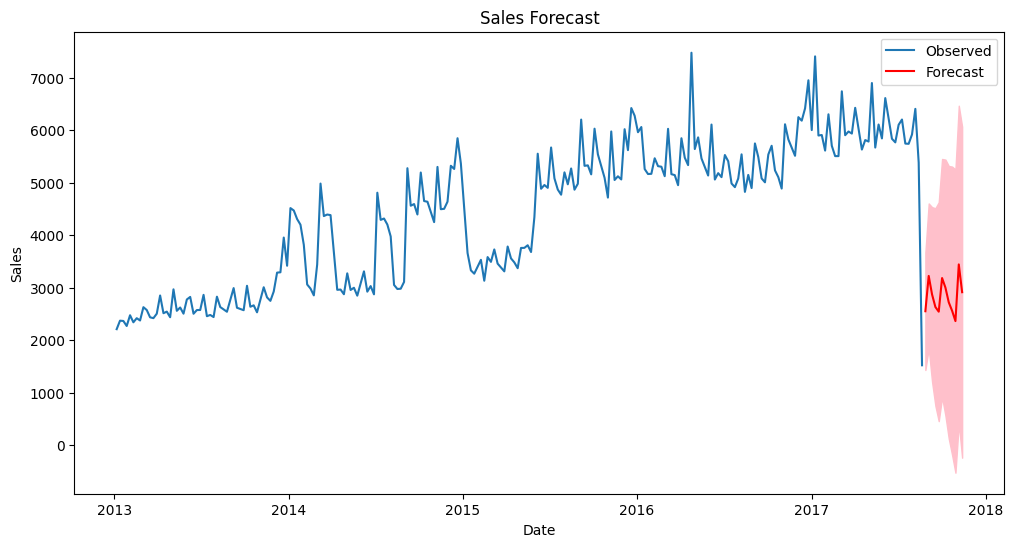

In [148]:
  
# Forecast future values
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [149]:
 
observed = weekly_sales[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmsle = root_mean_squared_log_error(observed, forecast_mean)
rmse=root_mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'RMSLE: {rmsle}')

MAE: 3021.309533841429
MSE: 9666077.862458985
RMSE: 3109.031659931913
RMSLE: 0.7615770094137034


In [78]:
es

NameError: name 'es' is not defined

In [ ]:
xgboost